In [1]:
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import urllib.request
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")
df_stars = pd.read_csv("stars.csv")
#df_stars.values[:,:4]

In [3]:
df_stars_data = df_stars.values[:,:4]

In [4]:
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


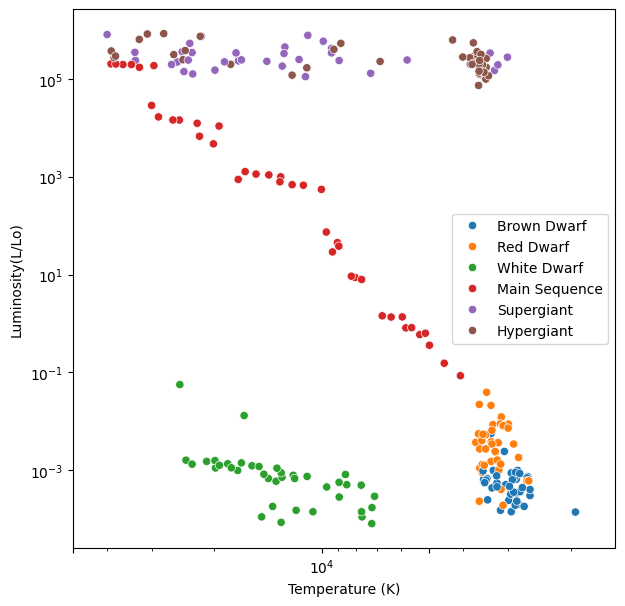

In [5]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)
plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

In [6]:
# Compute PCA

n_components = 4

# use Randomized PCA for speed
# pca = RandomizedPCA(n_components)
pca = PCA(n_components, svd_solver='randomized')
pca.fit(df_stars_data)
projected_data = pca.fit_transform(df_stars_data)
projected_data.shape

(240, 4)

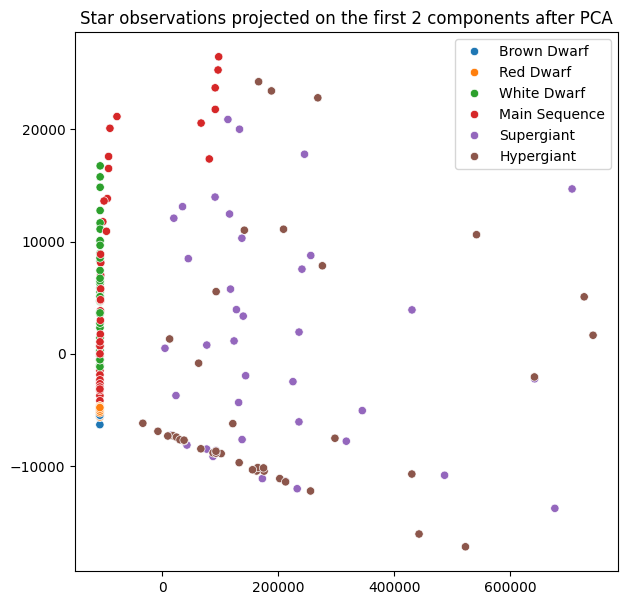

In [7]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x=projected_data[:,0], y=projected_data[:,1], hue=labels)
plt.title("Star observations projected on the first 2 components after PCA")
plt.show()

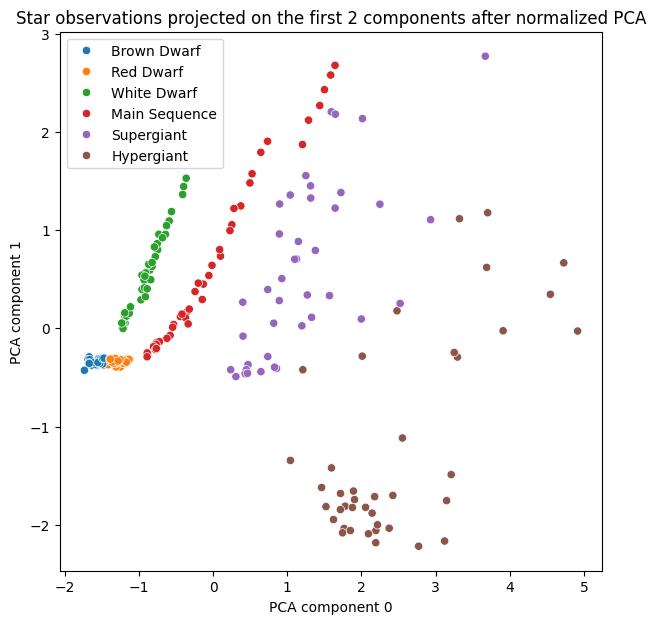

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(df_stars_data)

pca = PCA()
projected_data = pca.fit_transform(X)

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x=projected_data[:,0], y=projected_data[:,1], hue=labels)
plt.xlabel("PCA component 0")
plt.ylabel("PCA component 1")

plt.title("Star observations projected on the first 2 components after normalized PCA")
plt.show()

In [9]:
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Expained fractional variance of data encapsulated in the eigenvalues: [0.60357391 0.23500784 0.09329645 0.0681218 ]


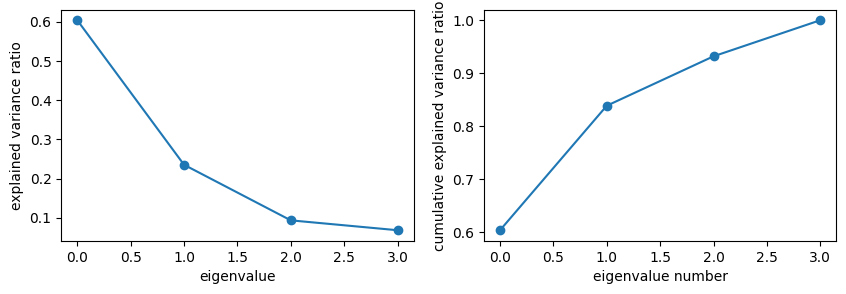

In [10]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)

ax.plot(np.arange(n_components), evals)
ax.scatter(np.arange(n_components), evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

ax = fig.add_subplot(122)

ax.plot(np.arange(n_components), evals.cumsum())
ax.scatter(np.arange(n_components), evals.cumsum())

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

In [11]:
for num_feats in np.arange(1,20, dtype = int):
    best_pca = PCA(n_components=num_feats)
    best_pca.fit(projected_data)
    if (sum(best_pca.explained_variance_ratio_)>0.995):
        break
print("{:d} features are needed to explain 99.5% of the variance".format(num_feats))

4 features are needed to explain 99.5% of the variance


In [12]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=6) #Try 2 clusters to start with, but the number of clusters is an hyperparameter
clf.fit(projected_data[:, 0:2])
centers = clf.cluster_centers_ #location of the clusters
labels_km = clf.predict(projected_data[:, 0:2]) #labels for each of the points

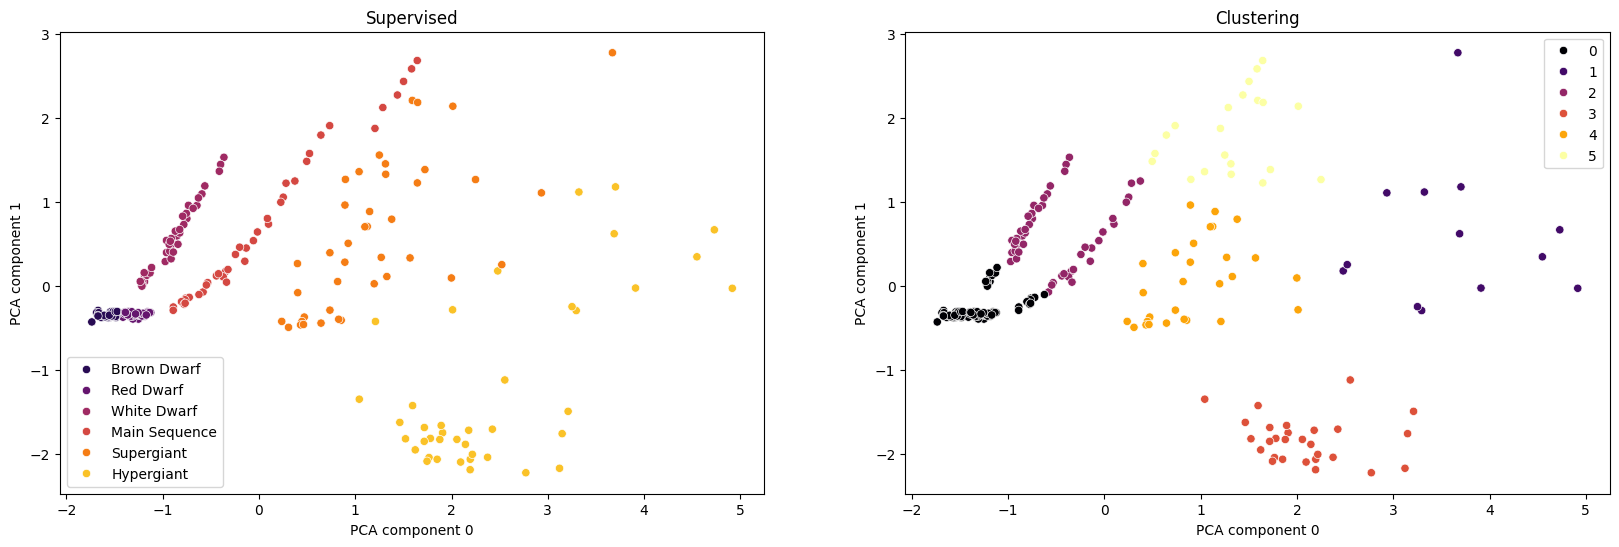

In [13]:
fig = plt.figure(figsize=(20, 6))

ax = fig.add_subplot(121)

sns.scatterplot(x=projected_data[:,0], y=projected_data[:,1], hue=labels, palette = 'inferno')

ax.set_xlabel("PCA component 0")
ax.set_ylabel("PCA component 1")
ax.set_title('Supervised')

ax = fig.add_subplot(122)

sns.scatterplot(x=projected_data[:,0], y=projected_data[:,1], hue=labels_km, palette = 'inferno')

ax.set_xlabel("PCA component 0")
ax.set_ylabel("PCA component 1")
ax.set_title('Clustering')
plt.show()

In [14]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

bandwidth = 0.4
#bandwidth = estimate_bandwidth(X) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False,
               seeds = centers)
ms.fit(projected_data[:, 0:2])

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False,
          seeds=array([[-1.33211218, -0.27984995],
       [ 3.6135973 ,  0.58836156],
       [-0.51087306,  0.63801805],
       [ 2.07826181, -1.82653784],
       [ 0.92253669,  0.05421618],
       [ 1.32170227,  1.81239994]]))

[-1  0  1  2  3  4  5]
0.4
number of estimated clusters : 6


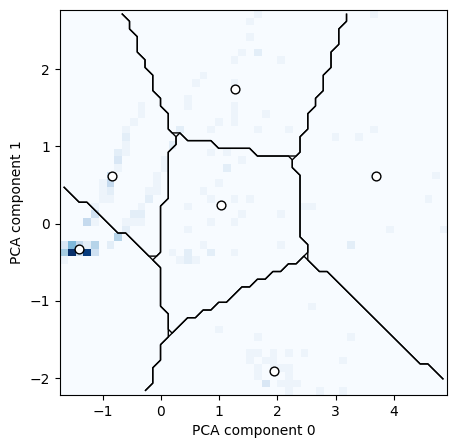

In [17]:
n_clusters=6
labels_unique = np.unique(ms.labels_)
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(projected_data[:,0], projected_data[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
ax.scatter(ms.cluster_centers_[:, 0], ms.cluster_centers_[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(Xgrid).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(Xgrid).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel("PCA component 0")
ax.set_ylabel("PCA component 1")

plt.show()